# Imports

In [ ]:
import numpy as np
import tensorflow as tf
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
import visualkeras as vk
tf.__version__
from tensorflow.keras.utils import to_categorical


# Custom Functions

In [3]:
# Define custom function
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes


In [4]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs



In [5]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)



In [6]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)



In [7]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



In [8]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    
    return results_dict



# Preprocessing

In [18]:
# Checking the contents of dataset folder 
data_dir = "C:\\Users\\Ashraf\\Documents\\X_reay\\x_raye"
os.listdir(data_dir)
img_files =(glob.glob(data_dir +'*/**/*'))
len(img_files)

6939

In [24]:
# Preview an example image (at full size) 
img_loaded = load_img(img_files[5])
img_data = img_to_array (img_loaded)
img_data.shape

(1308, 1652, 3)

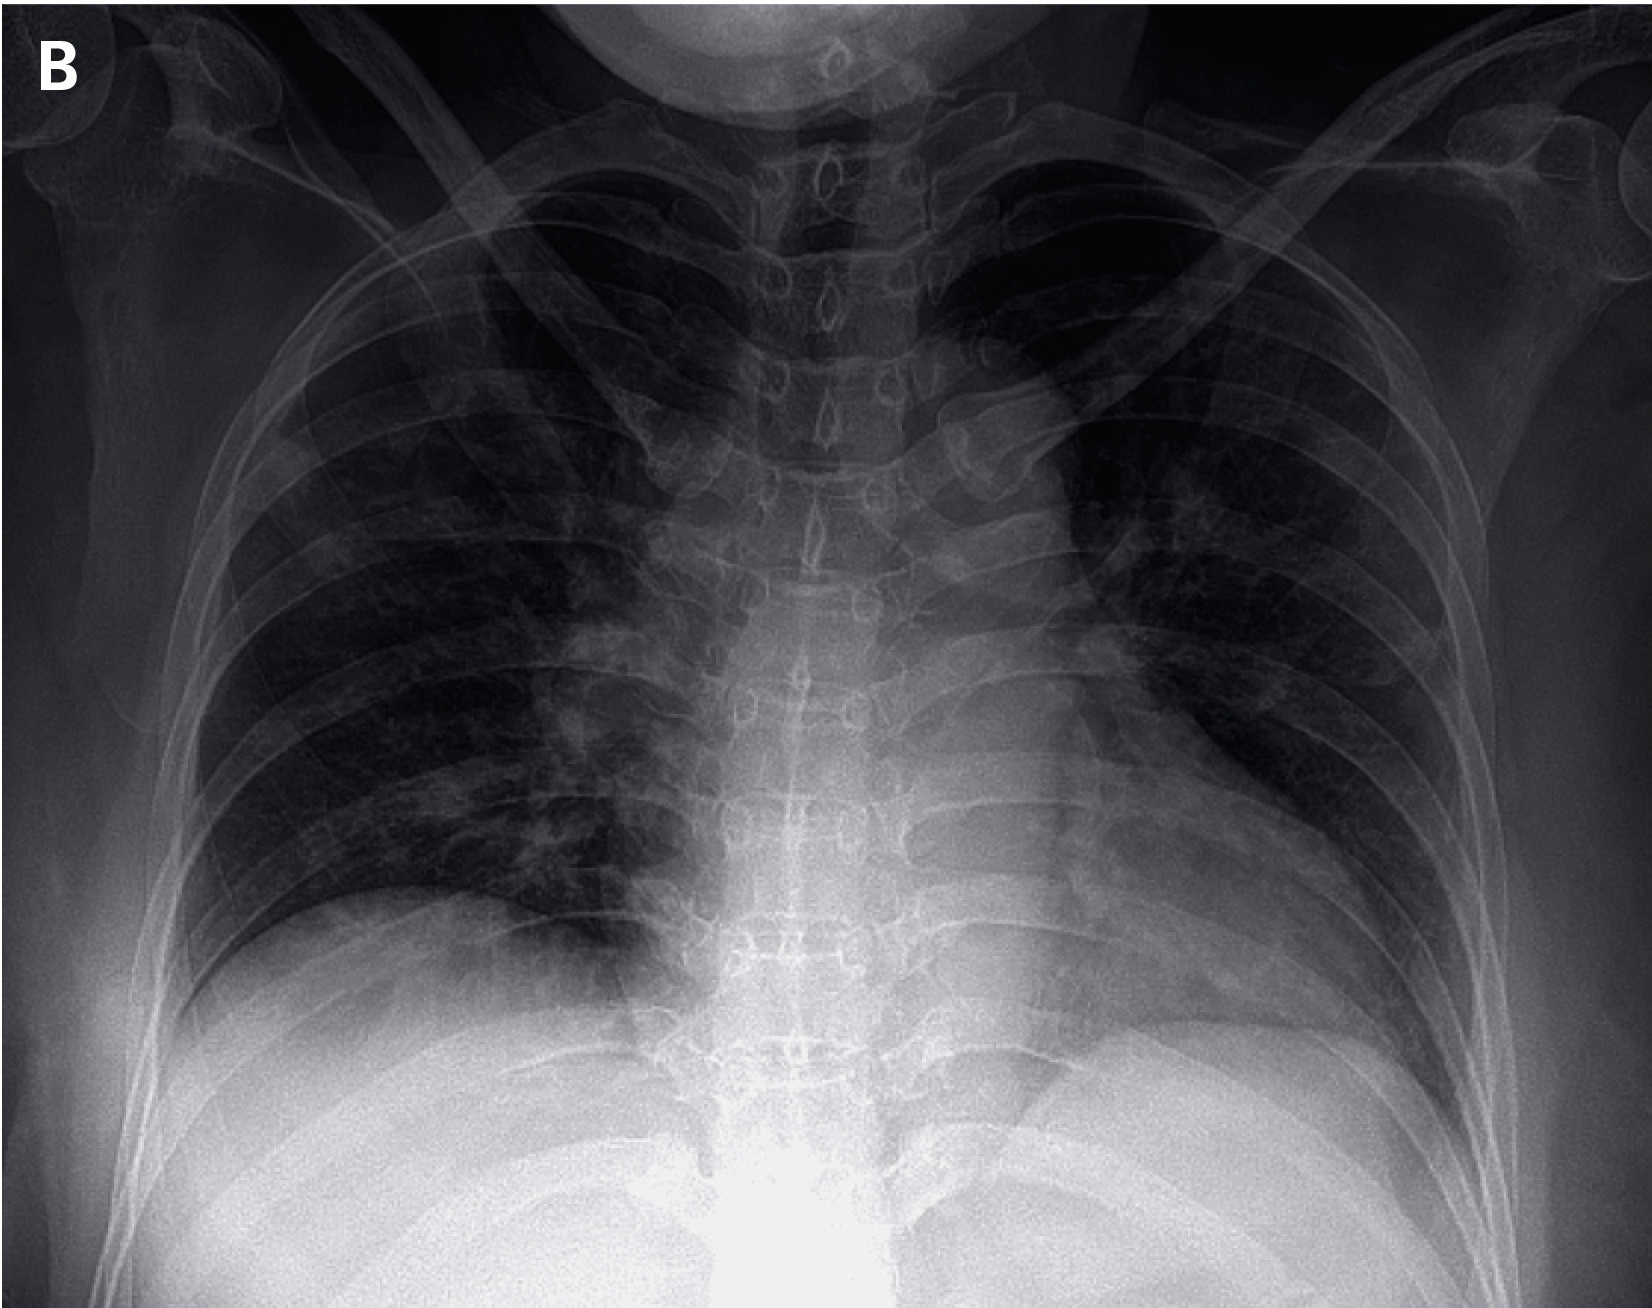

In [25]:
#array to img 
array_to_img(img_data)

## Creating an image_dataset_from_directory 

In [26]:
# Saving image params as vars for reuse 
batch_size = 32 
img_height = 128 
img_width = 128 

In [28]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(directory=data_dir ,  
                                                 label_mode= 'categorical' ,
                                                 batch_size=batch_size,
                                                 image_size=(img_height ,img_width),
                                                 shuffle=True,
                                                 seed= tf.random.set_seed(42) ,
                                                     
)

Found 6902 files belonging to 3 classes.


In [39]:
# len data  
ds_size=len(ds)

In [65]:
# taking a sample batch to see batch shape 
example_batch_imge ,example_batch_y = ds.take(1).get_single_element()
example_batch_imge.shape

TensorShape([32, 128, 128, 3])

In [35]:
class_name=ds.class_names
num_class =  len(class_name)
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_class), class_name))
class_dict



{0: 'covid', 1: 'normal', 2: 'pneumonia'}

In [37]:
input_shape = example_batch_imge[0].shape
input_shape

TensorShape([128, 128, 3])

## Train, Validation, and Test Split 

In [40]:
split_train = 0.7 
split_val = 0.2 
split_test = 0.1 
# Calculate the number of batches for training and validation data 
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 151 batches as training data
Use 43 batches as validation data
The remaining 22 batches will be used as test data.


In [41]:
# Use .take to slice out the number of batches
train_ds  = ds.take(n_train_batches)
len(train_ds)

151

In [42]:
# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds =ds.take(n_val_batches) 
len(val_ds)


43

In [43]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches+n_val_batches)
len(test_ds)

22

# Modeling

## 1) Build a Simple CNN Model

In [45]:
def build_model(): 
      # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layers = layers.Rescaling(1/255 ,input_shape = input_shape)
    model.add(scaling_layers) 
     # Convolutional layer 
    model.add(layers.Conv2D(filters=10 , kernel_size=3 ,input_shape = input_shape ,padding="same"))
     # Pooling layer 
    model.add(layers.MaxPool2D(pool_size=2))
    # Convolutional layer 
    model.add(layers.Conv2D(filters=8, padding='same',kernel_size=3))
    # Pooling layer 
    model.add(layers.MaxPool2D(pool_size=2 ))
    # Flattening layer
    model.add(layers.Flatten())
    # dense layers 
    model.add(layers.Dense(1024 , activation='relu'))
    model.add(layers.Dense(512 , activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128 , activation='relu'))
    # add Dropout 
    model.add(layers.Dropout(0.4))
     # Output layer
    model.add(
        layers.Dense(num_class, activation="softmax"))


    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model
    
    
    


    
    

###  Optimizing Dataset Performance 

In [52]:
# Make buffer size the same as the number of batches in train_ds
#buffer_size = len(train_ds)

# Use autotune to automatically determine best buffer sizes 
 #AUTOTUNE = tf.data.AUTOTUNE

# Optimize training data
#train_ds = train_ds.cache().shuffle(buffer_size= buffer_size,
                                   #seed=42).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

 

 

In [49]:
model1 =build_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 10)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 8)         728       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)             

In [53]:
def get_calbacks(): 
    early_stopping= tf.keras.callbacks.EarlyStopping(
        patience=4 , monitor='val_accuracy')
    return [early_stopping]
    

In [55]:
epochs = 20 
history = model1.fit (train_ds ,epochs=epochs , validation_data=val_ds , 
                      callbacks=get_calbacks()

    
)

Epoch 1/20
151/151 [==============================] - 168s 1s/step - loss: 0.6426 - accuracy: 0.7438 - val_loss: 0.4551 - val_accuracy: 0.8227
Epoch 2/20
151/151 [==============================] - 70s 451ms/step - loss: 0.3226 - accuracy: 0.8889 - val_loss: 0.2051 - val_accuracy: 0.9281
Epoch 3/20
151/151 [==============================] - 80s 525ms/step - loss: 0.2120 - accuracy: 0.9298 - val_loss: 0.1535 - val_accuracy: 0.9484
Epoch 4/20
151/151 [==============================] - 71s 457ms/step - loss: 0.1965 - accuracy: 0.9383 - val_loss: 0.1627 - val_accuracy: 0.9491
Epoch 5/20
151/151 [==============================] - 74s 480ms/step - loss: 0.1673 - accuracy: 0.9464 - val_loss: 0.1010 - val_accuracy: 0.9717
Epoch 6/20
151/151 [==============================] - 70s 453ms/step - loss: 0.1193 - accuracy: 0.9605 - val_loss: 0.1336 - val_accuracy: 0.9462
Epoch 7/20
151/151 [==============================] - 70s 456ms/step - loss: 0.1089 - accuracy: 0.9656 - val_loss: 0.0938 - val_accu

(<Figure size 600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'accuracy'}>], dtype=object))

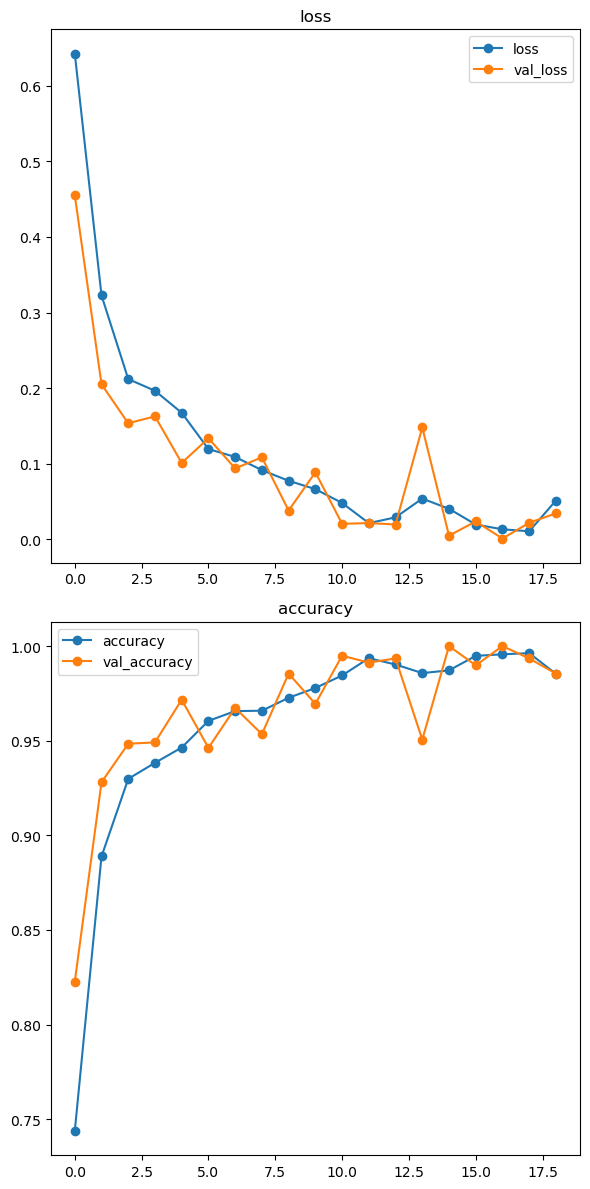

In [56]:
plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       221
           1       0.87      0.85      0.86       251
           2       0.89      0.88      0.89       222

    accuracy                           0.89       694
   macro avg       0.89      0.89      0.89       694
weighted avg       0.89      0.89      0.89       694



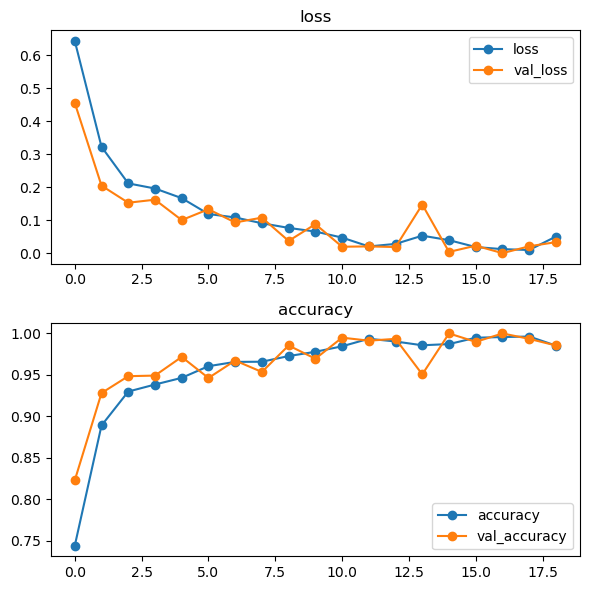

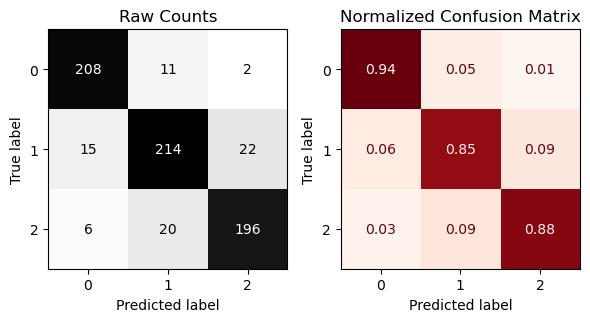


- Evaluating Test Data:
22/22 [==============================] - 33s 174ms/step - loss: 0.4735 - accuracy: 0.8847
{'loss': 0.4735121428966522, 'accuracy': 0.8847262263298035}


In [57]:
# Testing with the CNN + Dataset
evaluate_classification_network(model1, X_test=test_ds, history=history);

In [58]:
class_dict

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

## Data Augmentation 

In [61]:
# Creating the data augmentation "model"
data_augmentation = models.Sequential(
    [
        # Randomly flip image orientation
        layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
        # Randomly rotate the image (+ values means rotating counter clock-wise)
        layers.RandomRotation(0.15),
        layers.RandomZoom(
            height_factor=(-0.2, 0.2),  # Zoom in or out up to 20% (height)
            width_factor=(-0.2, 0.2),  # Zoom in or out up to 20% (width)
        ),
    ]
)
data_augmentation



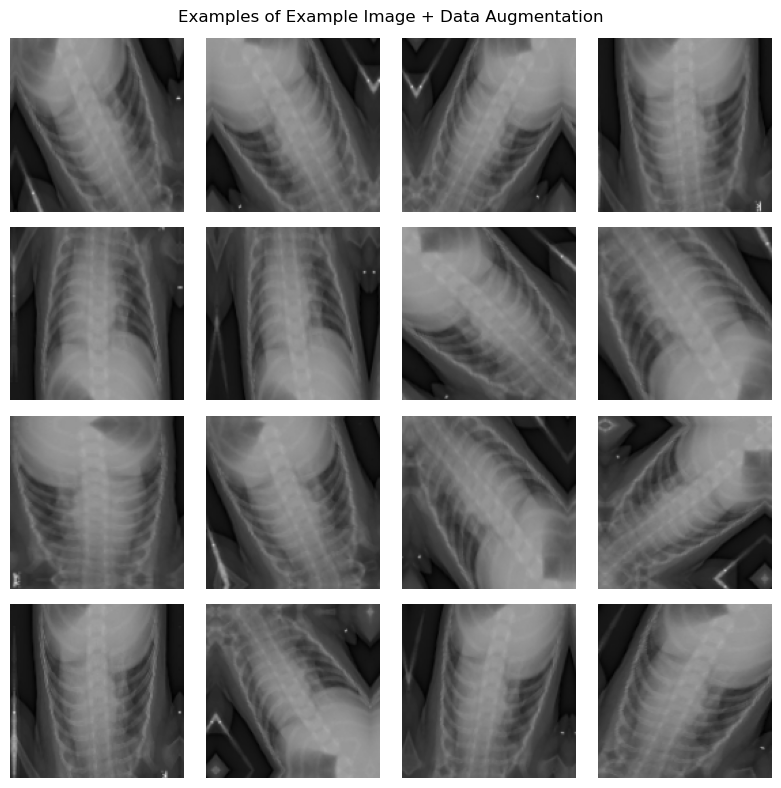

In [64]:
# plot the same example augmented 16 times
fig, axes = plt.subplots(figsize=(8, 8), nrows=4, ncols=4)
axes = axes.flatten()
for images, _ in train_ds.take(1):
  for i,ax in enumerate(axes):
    ## Apply a round of data_augmentation and plot the same image 
    augmented_images = data_augmentation(example_batch_imge)
    ax.imshow(augmented_images[5].numpy().astype(int))#, cmap='gray')
    ax.axis("off")
      
fig.suptitle('Examples of Example Image + Data Augmentation');
fig.tight_layout()



In [69]:
def build_model(): 
      # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layers = layers.Rescaling(1/255 ,input_shape = input_shape)
    model.add(scaling_layers) 

    data_augmentation = models.Sequential(
    [
        # Randomly flip image orientation
        layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
        # Randomly rotate the image (+ values means rotating counter clock-wise)
        layers.RandomRotation(0.15),
        layers.RandomZoom(
            height_factor=(-0.2, 0.2),  # Zoom in or out up to 20% (height)
            width_factor=(-0.2, 0.2),  # Zoom in or out up to 20% (width)
                  ), 
                   ])
    # Convolutional layer 
    model.add(layers.Conv2D(filters=10 , kernel_size=3 ,input_shape = input_shape ,padding="same"))
     # Pooling layer 
    model.add(layers.MaxPool2D(pool_size=2))
    # Convolutional layer 
    model.add(layers.Conv2D(filters=8, padding='same',kernel_size=3))
    # Pooling layer 
    model.add(layers.MaxPool2D(pool_size=2 ))
    # Flattening layer
    model.add(layers.Flatten())
    # dense layers 
    model.add(layers.Dense(1024 , activation='relu'))
    model.add(layers.Dense(512 , activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128 , activation='relu'))
    # add Dropout 
    model.add(layers.Dropout(0.4))
     # Output layer
    model.add(
        layers.Dense(num_class, activation="softmax"))


    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
    return model
    

In [70]:
model2 = build_model()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 10)      280       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 8)         728       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 8192)             

In [71]:
epochs = 20 

history2 = model2.fit(train_ds , epochs=epochs , validation_data=val_ds , shuffle=True, callbacks=get_calbacks
    
)

Epoch 1/20
151/151 [==============================] - 69s 438ms/step - loss: 0.6088 - accuracy: 0.7595 - val_loss: 0.3567 - val_accuracy: 0.8735
Epoch 2/20
151/151 [==============================] - 70s 452ms/step - loss: 0.2913 - accuracy: 0.9050 - val_loss: 0.2155 - val_accuracy: 0.9230
Epoch 3/20
151/151 [==============================] - 73s 477ms/step - loss: 0.2465 - accuracy: 0.9187 - val_loss: 0.1587 - val_accuracy: 0.9535
Epoch 4/20
151/151 [==============================] - 72s 467ms/step - loss: 0.1865 - accuracy: 0.9408 - val_loss: 0.1183 - val_accuracy: 0.9615
Epoch 5/20
151/151 [==============================] - 70s 457ms/step - loss: 0.1442 - accuracy: 0.9549 - val_loss: 0.1348 - val_accuracy: 0.9571
Epoch 6/20
151/151 [==============================] - 70s 457ms/step - loss: 0.1370 - accuracy: 0.9549 - val_loss: 0.1047 - val_accuracy: 0.9658
Epoch 7/20
151/151 [==============================] - 69s 451ms/step - loss: 0.1370 - accuracy: 0.9538 - val_loss: 0.0897 - val_ac

(<Figure size 600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'accuracy'}>], dtype=object))

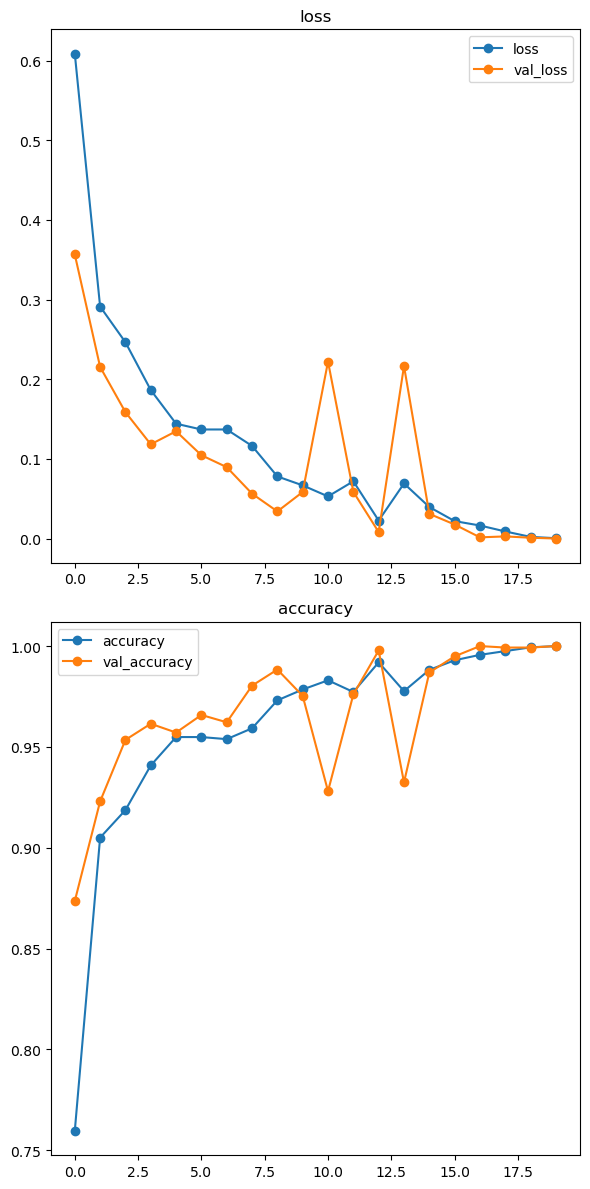

In [72]:
plot_history(history2 
            )


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       224
           1       0.86      0.85      0.86       241
           2       0.90      0.87      0.88       229

    accuracy                           0.89       694
   macro avg       0.89      0.89      0.89       694
weighted avg       0.89      0.89      0.89       694



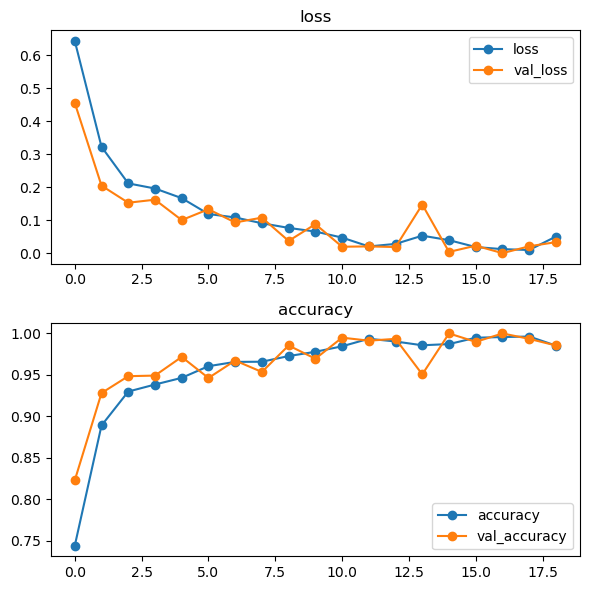

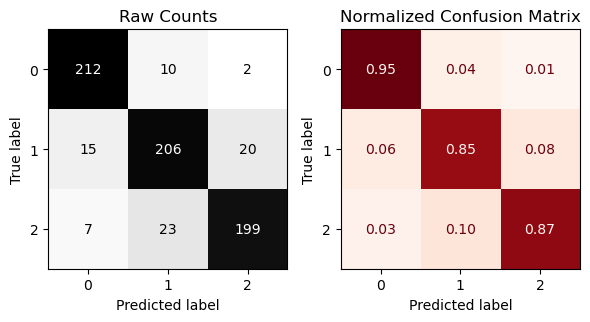


- Evaluating Test Data:
22/22 [==============================] - 34s 185ms/step - loss: 0.4588 - accuracy: 0.8977
{'loss': 0.45880356431007385, 'accuracy': 0.8976945281028748}


In [73]:
# Testing with the CNN + Dataset
evaluate_classification_network(model1, X_test=test_ds, history=history);

## Build a Transfer Learning Modeling Using a Keras Application

### VGG16

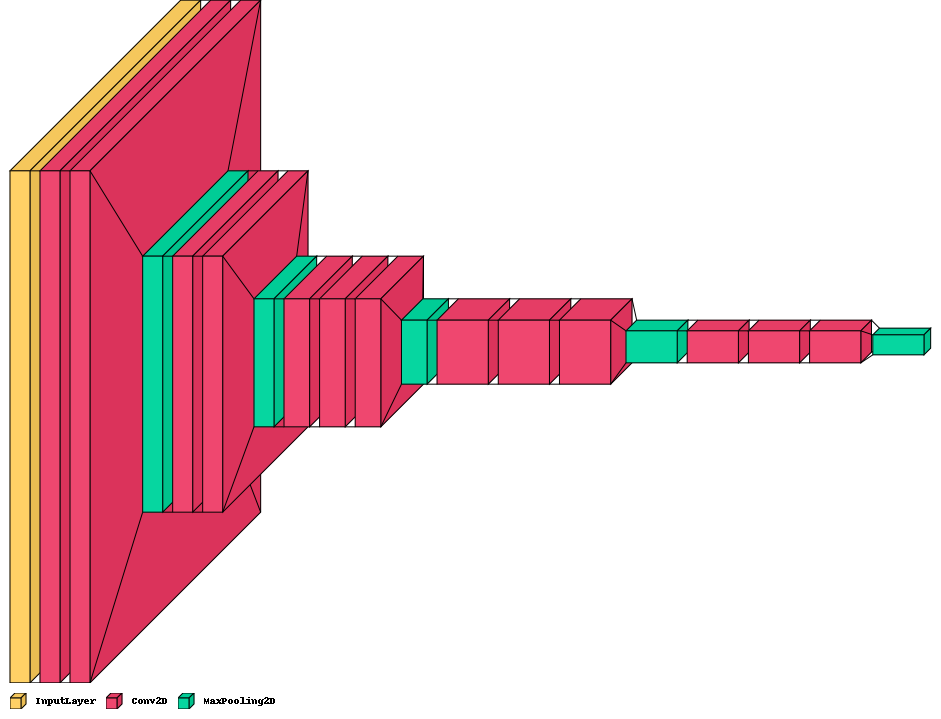

In [74]:
vgg_base = tf.keras.applications.VGG16(include_top=False ,weights = 'imagenet' , input_shape= input_shape )
vk.layered_view(vgg_base , legend= True)

In [78]:
# Check if base is trainable
vgg_base.trainable = False
vgg_base.trainable

False

In [79]:
# Preprocessing Images for Pretrained Models 


tf.keras.applications.vgg16.preprocess_input?



Signature: tf.keras.applications.vgg16.preprocess_input(x, data_format=None)
Docstring:
Preprocesses a tensor or Numpy array encoding a batch of images.

Usage example with `applications.MobileNet`:

```python
i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.mobilenet.preprocess_input(x)
core = tf.keras.applications.MobileNet()
x = core(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

image = tf.image.decode_png(tf.io.read_file('file.png'))
result = model(image)
```

Args:
  x: A floating point `numpy.array` or a `tf.Tensor`, 3D or 4D with 3 color
    channels, with values in the range [0, 255].
    The preprocessed data are written over the input data
    if the data types are compatible. To avoid this
    behaviour, `numpy.copy(x)` can be used.
  data_format: Optional data format of the image tensor/array. Defaults to
    None, in which case the global setting
    `tf.keras.backend.image_data_format()` is used (unles

In [80]:
# Create a lambda layer for the preprocess input function for the model
lambda_layer_vgg16 = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input,                                       name='preprocess_input')
lambda_layer_vgg16



In [83]:
# Downloading just the convolutional base
vgg16_base = tf.keras.applications.VGG16(
    include_top=False, weights="imagenet", input_shape=input_shape
)
# Prevent layers from base_model from changing 
vgg16_base.trainable = False

# Create the preprocessing lamdba layer
# Create a lambda layer for the preprocess input function for the model
lambda_layer_vgg16 = tf.keras.layers.Lambda(
    tf.keras.applications.vgg16.preprocess_input, name="preprocess_input"
)


def build_vgg16_model():
    model = models.Sequential(name="VGG16")
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_vgg16)

    # Add pretrained base
    model.add(vgg16_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(class_name), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model


In [84]:
model_vgg16 = build_vgg16_model()
model_vgg16.summary()



Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_13 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 3)                 771       
                                                                 
Total params: 16,812,867
Trainable params: 2,098,179
Non-trai

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_17 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 3)                 771       
                                                                 
Total params: 16,812,867
Trainable params: 2,098,179
Non-trai

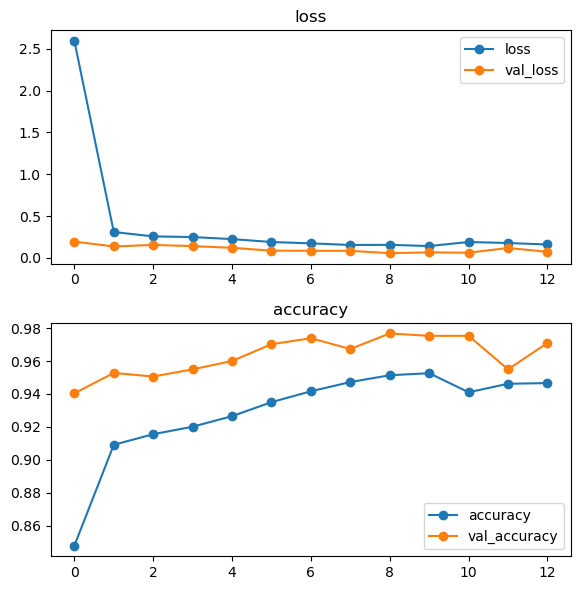

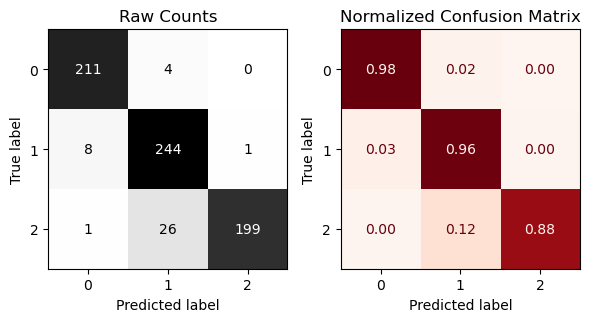


- Evaluating Test Data:
22/22 [==============================] - 92s 3s/step - loss: 0.2541 - accuracy: 0.9395
{'loss': 0.2541237771511078, 'accuracy': 0.939481258392334}


In [86]:
model_vgg16=build_vgg16_model()
history = model_vgg16.fit(train_ds, validation_data=val_ds,epochs=20, 
                    callbacks=get_calbacks()
                         )
evaluate_classification_network(model_vgg16,X_test=test_ds,history=history);

